# QWAK Tutorial - Stochastic Quantum Walks

In this notebook we are going to cover a couple of examples taken from the literature that showcase the use of Stochastic Quantum Walks (SQW). 

In particular we will see how to instantiate a SQW via the ```StochasticQWAK``` class. Then, we will learn how to use the noise parameter to simulate both purely quantum and classical walks and how to interpolate between them.
To conclude we will showcase the application of SQW to the problem of exiting a perfect maze.

If you haven't, install QWAK via the ```pip install qwak-sim``` command.

In [1]:
# !pip install --upgrade scipy>=1.8
# !pip install qwak-sim

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qwak.StochasticQwak import StochasticQWAK

After importing the ```StochasticQWAK``` class let's now formalize what a SQW is in order to understand the additional functionalities of this specific class with respect to the standard ```QWAK```.


The evolution of the system [[1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.022323),[2](https://iopscience.iop.org/article/10.1088/1367-2630/16/5/055015)] can be described by a Lindblad
master equation where the Hamiltonian of the system $H$ corresponds to the adjacency matrix itself, i.e. $H=A$, and with a
set of Lindblad operators acting as noise for the quantum walker, i.e.

$$
{\dot \rho} = -(1-p)\ i[H,\rho] + p\  L_{CRW} (\rho) + L_{sink} (\rho)
$$

with a term describing (for $p=1$) the regime of a classical random walk (CRW),
as

$$
    L_{CRW} (\rho) = \sum_{i,j} L_{ij} \rho L_{ij}^{\dagger} - \frac{1}{2} \{L_{ij}^\dagger L_{ij}, \rho\},
$$

with the Lindblad operators being defined as $L_{ij} =
(A_{ij}/d_j)|i><j|$, where $\lbrace d_j \rbrace$ are the node degrees. When $p=0$ one recovers the pure quantum walker regime, while $p=1$ corresponds to the classical scenario for a random walker. For the intermediate values of $p$ in the range $[0,1]$, one has a Stochastic Quantum Walker with an interplay between coherent evolution and noise effects. In addition, we can have a
special Lindblad operator that irreversibly transfers the population from an
"exit" node $n$ to the sink $S$ with a rate $\Gamma$, as follows

$$    
L_{sink} (\rho) = \Gamma \left [ 2|S><n|\rho |n><S| - \{|n><n|, \rho\} \right ].
$$

The sink $S$, which irreversibly traps the population constitutes a kind of
**exit** node and it can be useful to model phenomena such as energy
transfer.


In the end, with respect to the standard QWAK, this class has two more functionalities:


*   The possibility of having a noise parameter $p$ interpolating between a classical and a quantum walk.
*   The possibility of adding a sink (or exit) node $S$ from wich the population is drained from the graph.


It is worth noting here that, since we have a full Lindblad master equation, the numerical integration necessary to simulate the SQW becomes more involved. For these reasons ```StochasticQWAK``` makes use of [QuTiP](https://qutip.org/) to simulate the evolution of the walker.

Let's now start playing with a simple chain graph

In [3]:
n=100

graph = nx.path_graph(n)
qwak = StochasticQWAK(graph)

We have a chain of 100 nodes and we will run a Quantum Walk, i.e. $p=0$ (the class defaults to that when noiseParam is not specified), starting from the middle node.

Migrating e_ops, args, and options
Handling solver deprecation
Creating QobjEvo for H
Processing collapse operators
Determining whether to use mesolve or sesolve
Using sesolve


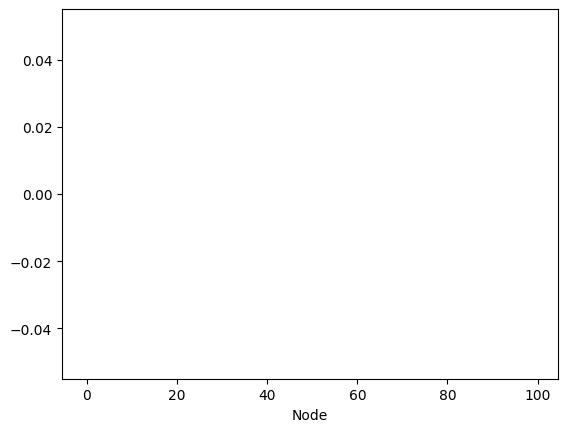

In [4]:
t=15
initState = [49]
qwak.runWalk(t,initState)

probVec = qwak.getProbVec()
plt.bar(np.arange(n),probVec,width=1.)
plt.xlabel('Node')
plt.show()

Here we can clearly observe the typical and well-known probability distribution of a Quantum Walk over a line with the two peaks. So, we can try and put a noiseParam > 0 to get a Stochastic Quantum Walk. In the limit of noiseParam = 1 (i.e $p=1$) we will get a Classical Random Walk.

In [ ]:
qwak = StochasticQWAK(graph,noiseParam=1)
t=20
initState = [49]
qwak.runWalk(t,initState)

probVec = qwak.getProbVec()
plt.bar(np.arange(n),probVec,width=1.)
plt.xlabel('Node')
plt.show()

Migrating e_ops, args, and options
Handling solver deprecation
Creating QobjEvo for H
Processing collapse operators
Determining whether to use mesolve or sesolve
Using MESOLVER


Indeed, as we observe the distribution of the state is now gaussian as we would expect from a classical walker.

To further demonstrate the capabilities of the `StochasticQWAK` class we will now introduce the custom `Maze` topology taken from [this paper](https://doi.org/10.1007/s42484-022-00068-y). In order to load the custom topology, scroll to the bottom of this notebook and run the corresponding cell, then come back here.


The following code instantiate a perfect maze of size $10 \times 10$ at random, a perfect maze is a maze in which there's one and only one path connecting the start node (blue) to the end node (red):.


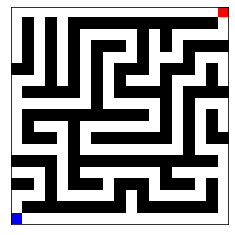

In [ ]:
maze_graph = Maze(maze_size=(10,10))
maze_graph.plot_maze()
plt.show()

Let's build our walker on this graph and see, at different times the probablity to exit the maze (notice that the sink node, set by the `sinkNode` index, is 99 in this case corresponding to the red node on the graph). 

In [ ]:
graph = nx.from_numpy_array(maze_graph.adjacency)
qwak = StochasticQWAK(graph,noiseParam=0,sinkNode=99,sinkRate=0.99)

exit_prob = []
times = []

for i in range(10):
  t=100*i
  initState = [0]
  qwak.runWalk(t,initState)

  probVec = qwak.getProbVec()
  exit_prob.append(probVec[-1])
  times.append(t)

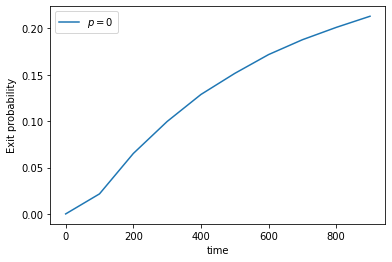

In [ ]:
plt.plot(times,exit_prob, label=r'$p=0$')
plt.xlabel('time')
plt.ylabel('Exit probability')
plt.legend()
plt.show()

Let's try again with the classical walker to compare their performances.

In [ ]:
graph = nx.from_numpy_array(maze_graph.adjacency)
qwak = StochasticQWAK(graph,noiseParam=1,sinkNode=99,sinkRate=0.99)

exit_prob_class = []
times = []

for i in range(10):
  t=100*i
  initState = [0]
  qwak.runWalk(t,initState)

  probVec = qwak.getProbVec()
  exit_prob_class.append(probVec[-1])
  times.append(t)

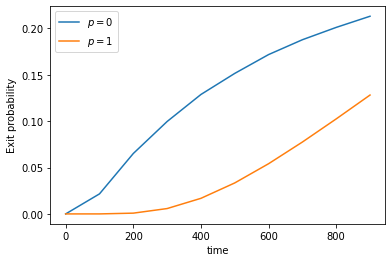

In [ ]:
plt.plot(times,exit_prob, label=r'$p=0$')
plt.plot(times,exit_prob_class, label=r'$p=1$')
plt.xlabel('time')
plt.ylabel('Exit probability')
plt.legend()
plt.show()

Again, let's do the same thing but with a 10 \% of noise, let's see if this is still worse than the purely quantum case.

In [ ]:
graph = nx.from_numpy_array(maze_graph.adjacency)
qwak = StochasticQWAK(graph,noiseParam=0.1,sinkNode=99,sinkRate=0.99)

exit_prob_opt = []
times = []

for i in range(10):
  t=100*i
  initState = [0]
  qwak.runWalk(t,initState)

  probVec = qwak.getProbVec()
  exit_prob_opt.append(probVec[-1])
  times.append(t)

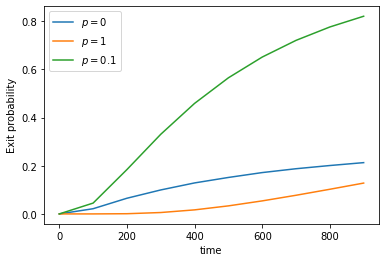

In [ ]:
plt.plot(times,exit_prob, label=r'$p=0$')
plt.plot(times,exit_prob_class, label=r'$p=1$')
plt.plot(times,exit_prob_opt, label=r'$p=0.1$')
plt.xlabel('time')
plt.ylabel('Exit probability')
plt.legend()
plt.show()

Indeed, that's much better!

This is exactly one of the results reported in a work about energy transport [[3](https://aip.scitation.org/doi/full/10.1063/1.3223548)], that highlights how a small amount of noise can actually be beneficial for the walker.

Now that you learned how to add noise to your walker and introduce sinks in your graph, you can exploit the full capabilities of SQWs 🎆🎆

# Maze custom topology

The original class can be found in [this](https://github.com/Buffoni/quantum_maze_learning) GitHub repository. If you find it useful or you make use of it please credit the authors.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#Author: Nicola Dalla Pozza

import numpy as np
import matplotlib.pyplot as plt
from random import randrange, shuffle


class Maze(object):

    def __init__(self, adjacency=None, maze_size=(20, 20), startNode=0, sinkNode=None):
        self.maze_size = maze_size
        self.width = int(self.maze_size[0])
        self.height = int(self.maze_size[1])

        if adjacency is None:
            self.adjacency = self.generate_adjacency_matrix(self.width, self.height)
        else:
            assert self.maze_size == adjacency.shape
            self.adjacency = adjacency

        self.total_nodes = self.width * self.height
        self.startNode = startNode
        self.sinkNode = sinkNode

        self.vertical_links = (self.height - 1) * self.width
        self.horizontal_links = (self.width - 1) * self.height
        self.total_links = self.vertical_links + self.horizontal_links

    @property
    def startNode(self):
        return self._startNode

    @startNode.setter
    def startNode(self, value):
        if value is None:
            self._startNode = 0
        else:
            assert 0 <= value < self.total_nodes, "startNode is outside the node range"
            self._startNode = value

    @property
    def sinkNode(self):
        return self._sinkNode

    @sinkNode.setter
    def sinkNode(self, value):
        if value is None:
            self._sinkNode = self.width * self.height - 1
        else:
            assert 0 <= value < self.total_nodes, "sinkNode is outside the node range"
            self._sinkNode = value

    def generate_adjacency_matrix(self, w, h):
        """Generate the adjacency matrix of a perfect maze given its width and height.
        Returns a np.array representing the adjacency matrix of a perfect maze with given width and height.
        adjacency[m, n] = 1 if there is a link between node m an n, 0 otherwise.
        The adjacency matrix is symmetric.
        Reference for the algorithm: https://rosettacode.org/wiki/Maze_generation#Python
        Parameters
        ----------
        w : int
            number of nodes in the x axis, i.e., the width of the maze
        h : int
            number of nodes in the y axis, i.e., the height of the maze
        Returns
        -------
        np.array, dtype='float64'
            symmetric adjacency matrix with entry A[i, j] = 1 if there is a link between node i and j, 0 otherwise
        """
        adjacency = np.zeros([h * w, h * w], dtype='float64')
        visited = [[0] * w + [1] for _ in range(h)] + [[1] * (w + 1)]

        def pos2node(x, y):
            return int(x * h + y)

        def walk(x, y):
            visited[y][x] = 1

            d = [(x - 1, y), (x, y + 1), (x + 1, y), (x, y - 1)]
            shuffle(d)
            for (xx, yy) in d:
                if visited[yy][xx]:
                    continue
                if xx == x:
                    adjacency[pos2node(x, yy), pos2node(x, y)] = 1
                    adjacency[pos2node(x, y), pos2node(x, yy)] = 1
                if yy == y:
                    adjacency[pos2node(x, y), pos2node(xx, y)] = 1
                    adjacency[pos2node(xx, y), pos2node(x, y)] = 1

                walk(xx, yy)

        walk(randrange(w), randrange(h))

        return adjacency

    def generate_maze_map(self):
        """Generate the maze map representing the maze as a pixel image from its adjacency matrix.
        The map has value 1 if a link is present (the corresponding coefficient in the adjacency matrix is > 0) while 0
        represents a wall. The size of the map is (maze.height * 2 - 1, maze.width * 2 - 1). There are no border walls.
        Returns
        -------
        np.array, dtype=int
            Matrix representing the maze as a pixel image. Value 1 represents a link, value 0 represents
            a wall. Size of the matrix (maze.height * 2 - 1, maze.width * 2 - 1).
        """
        maze_map = np.zeros([2 * self.height - 1, 2 * self.width - 1], dtype='int')
        for j in range(self.width - 1):  # defines the upper triangular part of the adjacency matrix
            for i in range(self.height - 1):
                if self.adjacency[j * self.height + i, j * self.height + i + 1] > 0:
                    maze_map[2 * i + 1, 2 * j] = 1
                if self.adjacency[j * self.height + i, (j + 1) * self.height + i] > 0:
                    maze_map[2 * i, 2 * j + 1] = 1
            i = self.height - 1  # last node has no upper neighbour
            if self.adjacency[j * self.height + i, (j + 1) * self.height + i] > 0:
                maze_map[2 * i, 2 * j + 1] = 1

        j = self.width - 1  # last node has no right neighbour
        for i in range(self.height - 1):
            if self.adjacency[j * self.height + i, j * self.height + i + 1] > 0:
                maze_map[2 * i + 1, 2 * j] = 1

        for n in range(self.width * self.height):
            x, y = self.node2xy(n)
            maze_map[y, x] = 1

        return maze_map

    def plot_maze(self, show_nodes=False, show_links=False, show_ticks=False, show=True):
        """Plot the map of the maze. White pixels (value 1) are paths while black pixels are walls.
        Plots a maze with different options, such as the possibility to plot the number corresponding to each link
        (in red) or node (in black bold) with the show_links and show_nodes option. Option startNode and
        sinkNode allow to insert the number of the start node or the sink node, which are plotted in blue and in
        red respectively.
        Parameters
        ----------
        show_nodes : bool (default False)
            options to show the node number on the corresponding pixel in black
        show_links : bool (default False)
            options to show the link number on the corresponding pixel in red
        show_ticks : bool (default False)
            options to show the coordinate ticks in the plot
        show : bool (default False)
            options to show the plot or not
        Returns
        -------
        numpy.ndarray, AxesImage
            numpy array with rgb colors for each pixel, AxesImage obtained from pyplot.imshow() (when plotted)
        """
        maze_map = self.generate_maze_map()
        xshift = 0.33
        yshift = 0.33
        cmap = plt.cm.get_cmap('gray')
        norm = plt.Normalize(maze_map.min(), maze_map.max())
        img = cmap(norm(maze_map))

        if self.startNode is not None:
            x, y = self.node2xy(self.startNode)
            img[y, x, :3] = 0, 0, 1
            # plt.text(x - xshift, y - yshift, str(self.startNode), fontweight='bold') # always print startNode

        if self.sinkNode is not None:
            x, y = self.node2xy(self.sinkNode)
            img[y, x, :3] = 1, 0, 0

        if show:
            if show_nodes:
                for n in range(self.height * self.width):
                    x, y = self.node2xy(n)
                    plt.text(x - xshift, y - yshift, str(n), fontweight='bold')

            if show_links:
                for n in range(1, (self.height - 1) * self.width + (self.width - 1) * self.height + 1):
                    x, y = self.link2xy(n)
                    plt.text(x, y - yshift, str(n), style='italic', color='red')

            if show_ticks:
                plt.xticks(np.arange(0, img.shape[1], step=4),
                           np.arange(0, (img.shape[1] - 1) / 2, step=2, dtype='int'))
                plt.yticks(np.arange(0, img.shape[0], step=4),
                           np.arange(0, (img.shape[0] - 1) / 2, step=2, dtype='int'))
            else:
                plt.xticks([])
                plt.yticks([])

            ax = plt.imshow(img, origin='lower')
            plt.show()

        else:
            ax = None

        return img, ax

    def set_link(self, link=None, value=None):
        """Set the value of a link in the maze.
        It updates the adjacency matrix in the maze changing the value associated with a link.
        Links are indexed  from 1 to self.total_links = (self.height-1)*self.width + (self.width-1)*self.height.
        Parameters
        ----------
        link : int
            index of the link to change. Its value is between 1 and self.total_links = (self.height-1)*self.width +
            (self.width-1)*self.height. Other values leave the maze unchanged.
        value : numpy.float64
            value to set to the link in the adjacency matrix.
        Returns
        -------
        numpy.float64
            returns the value set to the link
        """
        assert 1 <= link <= self.total_links
        if 1 <= link <= self.vertical_links:
            row = (link - 1) // (self.height - 1) * self.height + (link - 1) % (
                    self.height - 1)
            col = row + 1

        elif self.vertical_links < link <= self.total_links:
            row = link - (self.height - 1) * self.width - 1
            col = row + self.height

        self.adjacency[row, col] = value
        self.adjacency[col, row] = value

        return value

    def get_link(self, link=None):
        """Get the value of a link in the maze.
        Parameters
        ----------
        link : int
            index of the link to change. Its value is between 1 and self.total_links = (self.height-1)*self.width +
            (self.width-1)*self.height. Other values leave the maze unchanged.
        Returns
        -------
        numpy.float64
            returns the value of the link
        """
        assert 1 <= link <= self.total_links
        if 1 <= link <= self.vertical_links:
            row = (link - 1) // (self.height - 1) * self.height + (link - 1) % (
                    self.height - 1)
            col = row + 1

        elif self.vertical_links < link <= self.total_links:
            row = link - (self.height - 1) * self.width - 1
            col = row + self.height

        return self.adjacency[row, col]

    def reverse_link(self, link=None):
        """Reverse the value of a link in the maze, from 0 to 1 and vice-versa.
        It updates the adjacency matrix in the maze changing the value associated with a link.
        Links are indexed  from 1 to self.total_links = (self.height-1)*self.width + (self.width-1)*self.height.
        Parameters
        ----------
        link : int
            index of the link to change. Its value is between 1 and self.total_links = (self.height-1)*self.width +
            (self.width-1)*self.height. Other values leave the maze unchanged.
        Returns
        -------
        numpy.float64
            returns the value set to the link
        """
        value = self.get_link(link)
        if value == 0:
            self.set_link(link, value=np.float64(1))
            return np.float64(1)
        elif value > 0:
            self.set_link(link, value=np.float64(0))
            return np.float64(0)

    def node2xy(self, n):
        """Convert the index of the node into its coordinates x,y.
        Given a matrix representing a maze with size width and height, it converts the coordinates (x,y) to the index
        corresponding to a node. The nodes have even coordinates both in x and y, and are ordered along the columns,
        meaning that the 0-th node has coordinate (0,0), the 1-st has (0,2), ... the height-th has (2,0) and so on up to
        the width*height-1 th node with coordinates (2*width, 2*height).
        Parameters
        ----------
        n : int, from 0 to width*height-1
            index of the node
        Returns
        -------
        (int, int)
            Index representing the node
        """
        return 2 * (n // self.height), 2 * (n % self.height)

    def link2xy(self, n):
        """Convert the index of the link between two nodes into its coordinates x,y in the maze map.
        Given a matrix representing a maze with size width and height, it converts the coordinates (x,y) to the index
        corresponding to a link. The link are ordered with an index that runs first all the vertical links along the
        columns, then all the horizontal links, also along the columns.
        The vertical links are numbered from 1 to self.vertical_links, the horizontal links are numbered from
        self.vertical_links+1 to self.total_links. The 1-st link has coordinates (0,1), the 2-th has
        (0,3), ... the height-th has (2,1), ... the (height-1)*width+1 th (which is the first horizontal) has (1,0),
        then (1,2) and so on. Note that for a valid coordinate, x or y must be even.
        Parameters
        ----------
        n : int
            index representing the link
        Returns
        -------
        (x,y)
            x and y coordinates of the link, or numpy.nan if the parameters are invalid
        """
        if 1 <= n <= self.vertical_links:  # vertical link
            x, y = 2 * ((n - 1) // (self.height - 1)), 2 * ((n - 1) % (self.height - 1)) + 1

        elif self.vertical_links < n <= self.total_links:  # horizontal link
            n = n - self.vertical_links
            x, y = 2 * ((n - 1) // self.height) + 1, 2 * ((n - 1) % self.height)

        else:  # invalid parameters
            x, y = np.nan, np.nan

        return x, y